In [1]:
!pip install -q transformers diffusers accelerate sentence-transformers faiss-cpu clip-anytorch torch torchvision

import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer
import faiss
from diffusers import StableDiffusionPipeline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.

In [3]:
!pip install datasets
from datasets import load_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.3 MB/s eta 0:00:00


In [4]:
# Load the sentence embedding model for retrieval
retriever = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Load a text dataset for retrieval (Wikipedia excerpts)
dataset = load_dataset("wikipedia", "20220301.simple", split="train[:5000]")  # Small subset for testing
documents = dataset["text"]

# Encode all Wikipedia documents into vector representations
doc_embeddings = retriever.encode(documents, normalize_embeddings=True)

# Build FAISS Index for fast retrieval
dimension = doc_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(doc_embeddings, dtype=np.float32))

print(f"🔍 Indexed {len(documents)} Wikipedia documents for retrieval.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

wikipedia.py:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


train-00000-of-00001.parquet:   0%|          | 0.00/134M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/205328 [00:00<?, ? examples/s]

🔍 Indexed 5000 Wikipedia documents for retrieval.


In [5]:
# Load the sentence embedding model for retrieval
retriever = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Load a text dataset for retrieval (Wikipedia excerpts)
dataset = load_dataset("wikipedia", "20220301.simple", split="train[:5000]")  # Small subset for testing
documents = dataset["text"]

# Encode all Wikipedia documents into vector representations
doc_embeddings = retriever.encode(documents, normalize_embeddings=True)

# Build FAISS Index for fast retrieval
dimension = doc_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(doc_embeddings, dtype=np.float32))

print(f"🔍 Indexed {len(documents)} Wikipedia documents for retrieval.")


🔍 Indexed 5000 Wikipedia documents for retrieval.


In [19]:
import numpy as np

def retrieve_knowledge(query, top_k=5, max_sentences=3):
    """Retrieve relevant knowledge using FAISS with improved accuracy."""

    # Encode query to vector representation
    query_embedding = retriever.encode([query], normalize_embeddings=True)

    # Search FAISS index
    scores, indices = faiss_index.search(np.array(query_embedding, dtype=np.float32), top_k)

    # Retrieve top-k documents based on indices
    retrieved_texts = [documents[idx] for idx in indices[0]]

    # 🔹 (Optional) Split documents into sentences for more fine-grained retrieval
    refined_sentences = []
    for text in retrieved_texts:
        sentences = text.split(". ")  # Simple sentence segmentation
        refined_sentences.extend(sentences[:max_sentences])  # Take top sentences

    # Return joined retrieved info (limit max characters to avoid prompt overflow)
    retrieved_info = " ".join(refined_sentences[:max_sentences])[:700]

    return retrieved_info

# ✅ Test knowledge retrieval with the updated function
query = "A futuristic city with flying cars"
retrieved_info = retrieve_knowledge(query, top_k=5, max_sentences=3)

print(f"🔍 Query: {query}\n📖 Retrieved Info: {retrieved_info}...")



🔍 Query: A futuristic city with flying cars
📖 Retrieved Info: An aircraft is a flying machine 

The word aircraft originally meant airships and balloons It comes from the words air and craft,  a term from boating as were many early aviation words.

There are many different kinds of aircraft.

Some aircraft keep in the sky by moving air over their wings...


In [20]:
# Load Stable Diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

# Generate Image
enhanced_prompt = f"{query}. {retrieved_info}"
generated_image = pipe(enhanced_prompt).images[0]
generated_image.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

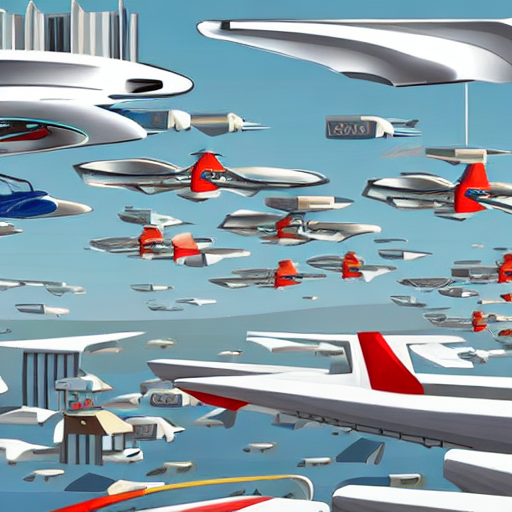

In [21]:
max_tokens = 76  # Keep some buffer
retrieved_info_short = " ".join(retrieved_info.split()[:max_tokens])
#enhanced_prompt = f"{query}. {retrieved_info_short}"
enhanced_prompt = f"Generate an image of {query}. Context: {retrieved_info}"

# Generate Image
generated_image = pipe(enhanced_prompt).images[0]

# Use display() for Jupyter/Colab compatibility
display(generated_image)

In [8]:
generated_image.show()

In [ ]:
# Load CLIP Model for Evaluation
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")




In [22]:
def clip_similarity(image, text):
    """Compute CLIP similarity score between image & text with truncation"""
    inputs = clip_processor(text=[text[:75]], images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    similarity = torch.cosine_similarity(outputs.image_embeds, outputs.text_embeds).item()
    return similarity


# Evaluate the RAG-enhanced image
similarity_score = clip_similarity(generated_image, enhanced_prompt)
print(f"CLIP Similarity Score: {similarity_score:.4f}")

CLIP Similarity Score: 0.3249
